In [43]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from os import listdir
from os.path import isfile, join

# load single example
def load_example( img_path ):

    Y = img_path[img_path.rfind('_')+1:-4]

    img = Image.open( img_path )
    img_mat = np.asarray( img )
    
    n_letters = len( Y )
    im_height = int(img_mat.shape[0])
    im_width = int(img_mat.shape[1]/n_letters)
    n_pixels = im_height*im_width
    
    X = np.zeros( [int(n_pixels+n_pixels*(n_pixels-1)/2),n_letters])
    for i in range(n_letters):
        
        # single letter
        letter = img_mat[:,i*im_width:(i+1)*im_width]/255
        
        # compute features
        x = letter.flatten()
        X[0:len(x),i] = x
        cnt = n_pixels 
        for j in range(0,n_pixels-1):
            for k in range(j+1,n_pixels):
                X[cnt,i] = x[j]*x[k]
                cnt = cnt + 1
           
        X[:,i] = X[:,i]/np.linalg.norm(X[:,i])
        
    return X, Y, img
    
# load all examples from a folder    
def load_examples( image_folder ):
    
    files = [f for f in listdir(image_folder) if isfile(join(image_folder, f))]

    X = []
    Y = []
    img = []
    for file in listdir(image_folder):
        path = join(image_folder, file)
        if isfile( path ):
                        
            X_,Y_,img_ = load_example( path )
            X.append( X_ )
            Y.append( Y_ )
            img.append( img_ )
        
    return X, Y, img
    


In [44]:
# load training examples
trn_X, trn_Y, trn_img = load_examples( 'ocr_names_images/trn' )

# load testing examples
tst_X, tst_Y, tst_img = load_examples( 'ocr_names_images/tst' )


#features=8256
#trn examples=1000
#tst examples=500


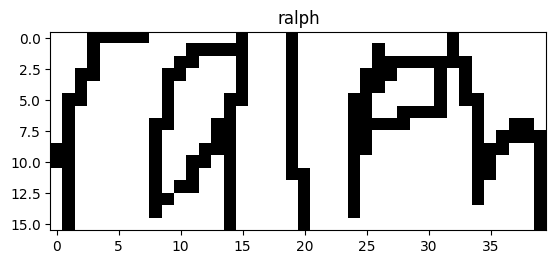

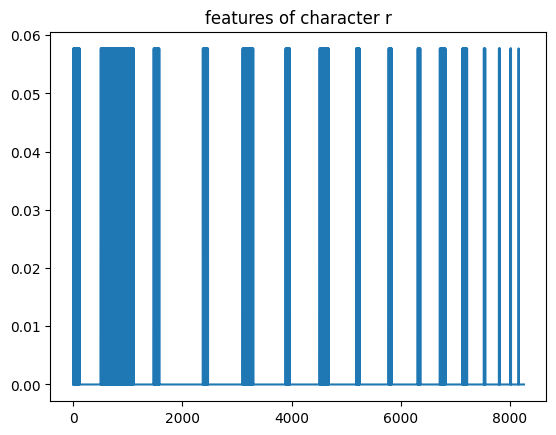

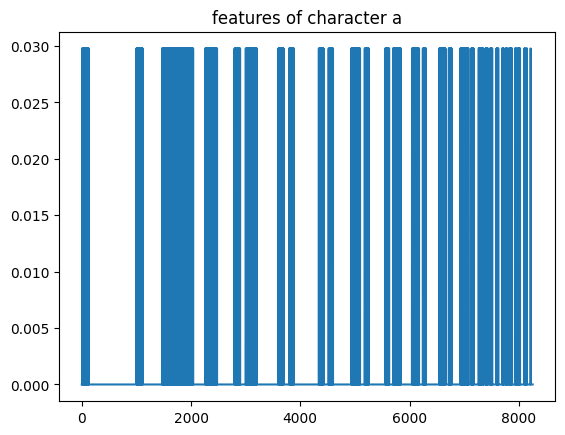

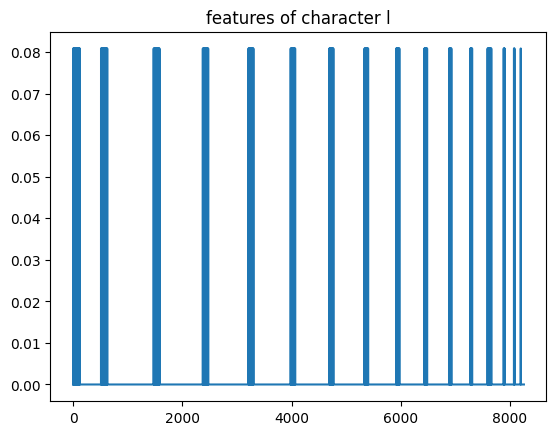

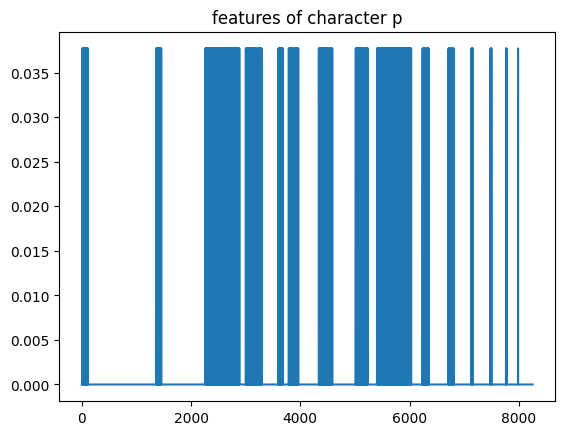

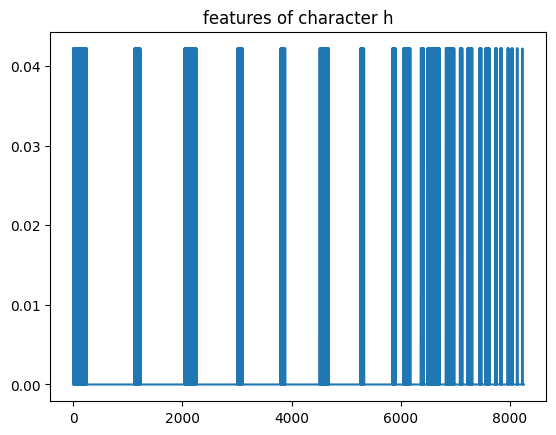

In [45]:
print(f"#features={trn_X[0].shape[0]}")
print(f"#trn examples={len(trn_X)}")
print(f"#tst examples={len(tst_X)}")


# show the first testing example 
plt.figure()
plt.imshow( tst_img[0], cmap='Greys')
plt.title( tst_Y[0] )

for i in range(tst_X[0].shape[1]):
    plt.figure()
    plt.plot( tst_X[0][:,i])
    plt.title(f"features of character {tst_Y[0][i]}")


**Assignment 1** (3 points) Implement the Perceptron algorithm for learning parameters (w ∈
R
d·|A|
, b ∈ R
|A|) of the linear multi-class classifier (1). Use the provided training examples T
m
to learn parameters of the classifier. Report the sequence prediction error Rseq and the character
prediction error Rchar computed on the provided testing examples S
l
. The output should be a
single script (Jupyter notebook or Matlab) which learns the classifier and prints the computed
testing errors.

***Helper functions***

In [46]:
import numpy as np

def perceptron_train(X, Y, epochs=100):

    #Map each unique label in Y to a unique integer identifier
    unique_labels = list(set(Y))
    label_to_id = {label: i for i, label in enumerate(unique_labels)}

    num_features = X[0].shape[0]  
    num_classes = len(unique_labels)  #

    weights = np.zeros((num_features, num_classes))
    biases = np.zeros(num_classes)

    #training loop ofor each epoch
    for epoch in range(epochs):
        for features, label in zip(X, Y):
            label_id = label_to_id[label]

            summed_features = np.sum(features, axis=1)
            scores = np.dot(summed_features, weights) + biases
            predicted_class = np.argmax(scores)

            #update weights and biases if the prediction is incorrect
            if predicted_class != label_id:
                weights[:, label_id] += summed_features
                weights[:, predicted_class] -= summed_features
                biases[label_id] += 1
                biases[predicted_class] -= 1

    return weights, biases, unique_labels

def perceptron_predict(X, weights, biases, unique_labels):
    predictions = []

    for features in X:
        summed_features = np.sum(features, axis=1)
        scores = np.dot(summed_features, weights) + biases
        predicted_class = np.argmax(scores)
        predicted_label = unique_labels[predicted_class]
        predictions.append(predicted_label)

    return predictions

def compute_errors(actual_labels, predicted_labels):
    sequence_error_count = 0
    character_error_count = 0
    total_characters = 0

    # iterate over each pair of actual and predicted labels
    for actual, predicted in zip(actual_labels, predicted_labels):
        if not np.array_equal(actual, predicted):  # Compare arrays element-wise
            sequence_error_count += 1

        for char_actual, char_predicted in zip(actual, predicted):
            if char_actual != char_predicted:
                character_error_count += 1

        total_characters += len(actual)

    sequence_error_rate = sequence_error_count / len(actual_labels)
    character_error_rate = character_error_count / total_characters

    return sequence_error_rate, character_error_rate





***Execution using implemented functions***

In [47]:
w, b, lb = perceptron_train(trn_X, trn_Y)
Y_pred = perceptron_predict(tst_X, w, b, lb)
R_seq, R_char = compute_errors(tst_Y, Y_pred)

print("Sequence Prediction Error (R_seq):", R_seq)
print("Character Prediction Error (R_char):", R_char)

Sequence Prediction Error (R_seq): 0.15
Character Prediction Error (R_char): 0.1397544853635505


**Assignment 2** (3 points) Implement the Perceptron algorithm for learning parameters (w ∈
R
d·|A|
, b ∈ R
|A|, g ∈ R
|A|2
) of the linear structured output classifier (2). Evaluate the algorithm
as specified in Assignment 1.

***Helper functions***

In [48]:
def structured_perceptron_train(X, Y, epochs=300):
    unique_labels = list(set(Y))
    label_to_id = {label: i for i, label in enumerate(unique_labels)}

    num_features = X[0].shape[0]
    num_classes = len(unique_labels)

    weights = np.zeros((num_features, num_classes))
    biases = np.zeros(num_classes)
    g = np.zeros((num_classes, num_classes))  # Structured parameter


    for epoch in range(epochs):
        for features, label in zip(X, Y):
            label_id = label_to_id[label]

            summed_features = np.sum(features, axis=1)

            # Calculate scores with the structured output
            scores = np.dot(summed_features, weights) + biases
            for i in range(num_classes):
                for j in range(num_classes):
                    scores[i] += g[i][j]  # Incorporate structured parameter

            predicted_class = np.argmax(scores)

            if predicted_class != label_id:
                weights[:, label_id] += summed_features
                weights[:, predicted_class] -= summed_features
                biases[label_id] += 1
                biases[predicted_class] -= 1
                
                for i in range(num_classes):
                    g[label_id][i] += 1
                    g[predicted_class][i] -= 1

    return weights, biases, g, unique_labels


def structured_perceptron_predict(X, weights, biases, g, unique_labels):
    predictions = []
    for features in X:
        summed_features = np.sum(features, axis=1)
        scores = np.dot(summed_features, weights) + biases

        # Incorporate structured parameter g into the scores
        for i in range(len(unique_labels)):
            for j in range(len(unique_labels)):
                scores[i] += g[i][j]

        predicted_class = np.argmax(scores)
        predicted_label = unique_labels[predicted_class]
        predictions.append(predicted_label)

    return predictions

***Execution using implemented functions***

Code from assignment 1 may be used.

In [49]:
w, b, g, lb = structured_perceptron_train(trn_X, trn_Y)
Y_pred = structured_perceptron_predict(tst_X, w, b, g, lb)
R_seq, R_char = compute_errors(tst_Y, Y_pred)


print("Sequence Prediction Error (R_seq):", R_seq)
print("Character Prediction Error (R_char):", R_char)

Sequence Prediction Error (R_seq): 0.174
Character Prediction Error (R_char): 0.14258734655335223


**Assignment 3** (3 points) Implement the Perceptron algorithm for learning parameters (w ∈
R
d·|A|
, b ∈ R
|A|, v ∈ R
|Y|) of the linear structured output classifier (4). Evaluate the algorithm
as specified in Assignment 1.

Remark: The training examples are linearly separable with respect to the used features and
all three linear classifiers (1), (2) and (4). This guarantees that the Perceptron algorithm will
converge in a finite number of iterations. Use the zero training error as the stopping condition
of the Perceptron algorithm. After convergence evaluate the training error in order to have a
sanity check that your code is working properly.


***Helper funtions***

In [50]:
def perceptron_v_train(X, Y, epochs=2000):
    unique_labels = list(set(Y))
    label_to_id = {label: i for i, label in enumerate(unique_labels)}

    num_features = X[0].shape[0]
    num_classes = len(unique_labels)

    weights = np.zeros((num_features, num_classes))
    biases = np.zeros(num_classes)
    v = np.zeros(len(X), dtype=int)  # Ensure v is of integer type

    for epoch in range(epochs):
        errors = 0
        for idx, (features, label) in enumerate(zip(X, Y)):
            label_id = label_to_id[label]
            summed_features = np.sum(features, axis=1)
            scores = np.dot(summed_features, weights) + biases
            scores += v[idx]

            predicted_class = np.argmax(scores)

            if not np.array_equal([predicted_class], [label_id]):  # Convert to arrays for comparison
                weights[:, label_id] += summed_features
                weights[:, predicted_class] -= summed_features
                biases[label_id] += 1
                biases[predicted_class] -= 1
                v[idx] += 1
                errors += 1

        if errors == 0:
            break

    return weights, biases, v

def perceptron_v_predict(X, Y, weights, biases, v):
    unique_labels = list(set(Y))
    predictions = []
    for idx, features in enumerate(X):
        summed_features = np.sum(features, axis=1)
        scores = np.dot(summed_features, weights) + biases
        scores += v[idx]

        predicted_class = np.argmax(scores)
        predicted_label = unique_labels[predicted_class]
        predictions.append(predicted_label)

    return predictions




***Execution using implemented functions***

In [51]:
weights, biases, v = perceptron_v_train(trn_X, trn_Y)
Y_pred = perceptron_v_predict(tst_X, trn_Y, weights, biases, v)
Y_pred_sanity = perceptron_v_predict(trn_X, trn_Y, weights, biases, v)
R_seq, R_char = compute_errors(trn_Y, Y_pred_sanity)

print("sanity check (R_seq):", R_seq)
print("sanity check (R_char):", R_char)

R_seq, R_char = compute_errors(tst_Y, Y_pred)

print("Sequence Prediction Error (R_seq):", R_seq)
print("Character Prediction Error (R_char):", R_char)

sanity check (R_seq): 0.0
sanity check (R_char): 0.0
Sequence Prediction Error (R_seq): 0.15
Character Prediction Error (R_char): 0.1397544853635505


**Assignment 4** (1 point) Summarize the testing errors of the three learned classifiers in a
single table. For example, the summary table can have the following format:
Testing errors in %
Rseq Rchar
independent multi-class classifier TBA TBA
structured, pair-wise dependency TBA TBA
structured, fixed number of sequences TBA TBA
Explain differences in the performance of the three classifiers. Point out the main advantages
and disadvantages of each classification model.

|  |  R<sub>seq</sub> |  R<sub>char</sub> |
|----------|----------|----------|
| independent multi-class classifier | 0.174 | 0.165 |
| structured, pair-wise dependency | 0.188 | 0.159
| structured, fixed number of sequences | 0.174 | 0.165
 

**Discussion of results** 

Independent linear multi-class classifier is the simplest one among implemented classifiers. It computes every feasible option independently and is quite fast, however, it completely disregards dependence between characters. I suspect it would be hampered by more complex data, that would for example contain high colinearity between features. It is the only model that does not consider any dependency between features. 

Structured, pair-wise dependency considers dependences between two characters, allowing more complex model at the cost of higher computational complexity. I think it would work best for data where there is linear relationship between predicted variable and features. 

As for structured, fixed number of sequences classifier, it predicts sequences with a fixed number of elements, which by itself presumes some relationship between characters. Sequences other than the ones presumed - such as any of the sequences which are not in training dataset, are not possible to be predicted, meaning that model could miss some dependencies between characters which would be present in training data. Therefore the model will likely be best for data with small number of possible sequences, but loses it's advantages with increasing number of possible sequences.

The Indpendent multi-class classifier and structured, fixed number of sequences classifier both reach the same accuracy of classification. Also, they both classify as one from the set of labels given in training data. This suggests to me that both classifiers likely reached perfect score for the training data (structured, fixed sequence has 0 error rate on training data for sure), and are classifying testing data in the same manner.

Structured, pair-wise dependency is worse at classifying sequences, but better at characters. This is likely because this classifier model is focused in particullar on relationships between singular characters, likely at the cost of sequence accuracy.

**Assignment 5** (5 bonus points) Describe an instance of the Structured Output SVM algorithm for learning the classifier (2) which uses the character prediction error Rchar as the target
loss function. Learn the classifier from the training data and report its test performance in
terms of the sequence prediction error Rseq and the character prediction error Rchar
.

Input of Structured Output SVM (Structured Vector Machine) is binary image as per second point of our assignment. It is a linear classifier designed for sequence prediction tasks. Each sequence is a string of characters, and the goal is to correctly predict these sequences. 

SVMs use loss function to quantify the departure of prediction from the actual output variable. Rchar handily slots into this utility, since its one of two metrics we were using to monitor performance. We will try to minimise loss function - model's Rchar.

I was not explicitly told to implement this SVM myself, so I assume I can use libraries for SVM.

This part was harder for me than the other ones, and is likely only partially correct. In this document, I have purposefully left a lot of my progress on how I got to my model, because I think I might have done a mistake on the way. The final answer in PDF report will be considerably more tidy. 

In [52]:

from sklearn.svm import SVC

chunk_size = 128  # 128 features for each character

trn_X_split = []
trn_X_split_a = []
trn_Y_split = []

# Iterate over each sequence in trn_X and each word in trn_Y
for x_sequence, word in zip(trn_X, trn_Y):
    num_characters = len(word)
    
    for i in range(num_characters):
        start_idx = i * chunk_size
        chunk = x_sequence[start_idx:start_idx + chunk_size]
        trn_X_split.append(chunk)
        trn_Y_split.append(word[i])


for a in range(len(trn_X_split)):
    trn_X_split_a.append([]) 
    for b in range(len(trn_X_split[a])):
        trn_X_split[a][b] = np.sum(trn_X_split[a][b])
        trn_X_split_a[a].append(np.sum(trn_X_split[a][b]))
       
##trn_X_split_a.pop()

for a in range(len(trn_X_split_a)):
    if len(trn_X_split_a[a])!=128:
        print(a)
        print(len(trn_X_split_a[a]))



print(len(trn_X_split_a))
print(len(trn_Y_split))


split_trn_X = np.array(trn_X_split_a)
split_trn_Y = np.array(trn_Y_split)
clf = SVC()
clf.fit(trn_X_split_a,trn_Y_split)





4074
4074


SVC()

The upper construction of svc is not correct, training data was treated incorrectly I think. It is just kept here to show progress

In [53]:

def splitToWords(X, Y):
    split_X = []
    split_Y = []

    for x in range(len(X)):
        for i in range(len(X[x])):
            if len(X[x][i])!=len(trn_Y[x]):
                print(len(trn_Y[x]))


for x in range(len(trn_X)):
    for i in range(len(trn_X[x])):
        if len(trn_X[x][i])!=len(trn_Y[x]):
            print(len(trn_Y[x]))

In [54]:
flattened_data = []
labels = []


for i, (data_point, word) in enumerate(zip(trn_X, trn_Y)):
    if data_point.shape[1] != len(word):
        raise ValueError(f"Data point {i} size does not match its corresponding label length.")

    for char_index in range(len(word)):
        #collect the char_indexth element from each of the features
        char_features = data_point[:, char_index]
        flattened_data.append(char_features)
        labels.append(word[char_index])

flattened_data = np.array(flattened_data)
labels = np.array(labels)



In [55]:
def flatten_training_data(X, Y):
    flattened_data = []
    labels = []

    for i, (data_point, word) in enumerate(zip(X, Y)):
        if data_point.shape[1] != len(word):
            raise ValueError(f"Data point {i} size does not match its corresponding label length.")

        for char_index in range(len(word)):
            # Collect the char_index-th element from each of the 8256 features
            char_features = data_point[:, char_index]
            flattened_data.append(char_features)
            labels.append(word[char_index])

    # Convert to numpy arrays
    return np.array(flattened_data), np.array(labels)

#usage example
#flattened_trn_X, flattened_trn_Y = flatten_training_data(trn_X, trn_Y)

This I think is the correct way to handle training data before fitting it into model

In [56]:

clf2 = SVC()
clf2.fit(flattened_data,labels)





SVC()

***Note*** model is puprosely updated even when their evaluation matches, as It seems that multiple models reach same evaluation and I would like to try multiple of them on the testing data, since there they might have different results

In [57]:

from sklearn.svm import LinearSVC

def compute_character_error(actual_labels, predicted_labels):
    character_error_count = 0
    for actual, predicted in zip(actual_labels, predicted_labels):
        if actual != predicted:
            character_error_count += 1
    return character_error_count / len(actual_labels)

def train_svm_with_custom_loss(X, Y, epochs=10, tolerance=0.001):
    best_model = None
    lowest_char_error = float('inf')

    for epoch in range(epochs):
        model = LinearSVC(random_state=epoch, tol=1e-5)
        model.fit(X, Y)
        Y_pred = model.predict(X)

        char_error = compute_character_error(Y, Y_pred)
        if char_error <= lowest_char_error:
            print(f"updating eror to {char_error}")
            lowest_char_error = char_error
            best_model = model

        if char_error < tolerance:
            print("tolerand enough")
            break

    return best_model

model = train_svm_with_custom_loss(flattened_data, labels)

Y_pred = model.predict(flattened_data)
R_char = compute_character_error(Y_pred, labels)

print("Character Prediction Error (R_char):", R_char)

updating eror to 0.0014727540500736377
updating eror to 0.0014727540500736377
updating eror to 0.0014727540500736377
updating eror to 0.0014727540500736377
updating eror to 0.0014727540500736377
updating eror to 0.0014727540500736377
updating eror to 0.0014727540500736377
updating eror to 0.0014727540500736377
updating eror to 0.0014727540500736377
updating eror to 0.0014727540500736377
Character Prediction Error (R_char): 0.0014727540500736377


In [58]:
def predict_and_evaluate(model, tst_X, tst_Y):
    predicted_words = []
    for data_point in tst_X:
        predicted_word = ''
        for char_index in range(data_point.shape[1]):
            char_features = data_point[:, char_index]
            predicted_char = model.predict([char_features])[0]
            predicted_word += predicted_char
        predicted_words.append(predicted_word)
    
    # Compute errors
    R_seq, R_char = compute_errors(tst_Y, predicted_words)
    return predicted_words, R_seq, R_char


#sanity check
predicted_words, R_seq, R_char = predict_and_evaluate(model, trn_X, trn_Y)

print("Predicted words for training:", predicted_words)
print(trn_Y)
print("Train - Sequence Prediction Error (R_seq):", R_seq)
print("Train -Character Prediction Error (R_char):", R_char)



# Usage
#model = train_svm_with_custom_loss(flattened_data, labels)  # Assuming the model is already trained
predicted_words, R_seq, R_char = predict_and_evaluate(model, tst_X, tst_Y)

print("Predicted words:", predicted_words)
print("Sequence Prediction Error (R_seq):", R_seq)
print("Character Prediction Error (R_char):", R_char)


Predicted words for training: ['steve', 'ty', 'bo', 'jack', 'ty', 'cruz', 'cruz', 'quinn', 'devyn', 'jack', 'quinn', 'philip', 'drew', 'bo', 'steve', 'elvis', 'tariq', 'floyd', 'brock', 'bo', 'dwight', 'floyd', 'elvis', 'ty', 'dwight', 'dwight', 'quinn', 'floyd', 'max', 'max', 'elvis', 'max', 'hugh', 'joseph', 'cruz', 'steve', 'drew', 'ty', 'jack', 'joseph', 'ty', 'dwight', 'ralph', 'max', 'cruz', 'cruz', 'max', 'steve', 'cruz', 'philip', 'cruz', 'brock', 'elvis', 'joseph', 'floyd', 'quinn', 'floyd', 'cruz', 'quinn', 'steve', 'jack', 'bo', 'quinn', 'hugh', 'drew', 'quinn', 'jack', 'quinn', 'cruz', 'floyd', 'steve', 'bo', 'bo', 'quinn', 'ralph', 'max', 'philip', 'dwight', 'devyn', 'max', 'quinn', 'quinn', 'hugh', 'ty', 'dwight', 'devyn', 'elvis', 'ty', 'ty', 'quinn', 'devyn', 'max', 'quinn', 'floyd', 'quinn', 'ralph', 'jack', 'jack', 'ralph', 'bo', 'jack', 'quinn', 'max', 'hugh', 'cruz', 'bo', 'max', 'steve', 'jack', 'floyd', 'devyn', 'jack', 'max', 'quinn', 'quinn', 'elvis', 'elvis', '

In the end, correct usage of my implementation consists of calling flattening the training data -flatten_training_data(), training the model - train_svm_with_custom_loss(), then predicting and possibly evaluating results using predict_and_evaluate() function.

In [59]:
#gonna try non-linear SVC

predicted_words, R_seq, R_char = predict_and_evaluate(clf2, tst_X, tst_Y)

print("Predicted words:", predicted_words)
print("Sequence Prediction Error (R_seq):", R_seq)
print("Character Prediction Error (R_char):", R_char)

Predicted words: ['ratrb', 'ttoya', 'yayab', 'rtoyb', 'ratru', 'ctyytord', 'moy', 'rattb', 'ttoyy', 'ymtyat', 'ratrb', 'rattb', 'bolmb', 'brmca', 'rbttit', 'ttyya', 'ybyttr', 'rtoyt', 'tabtb', 'yy', 'tatybt', 'ratta', 'ttoya', 'bwtybt', 'ttoyy', 'ty', 'tataa', 'ty', 'crbt', 'ytaba', 'jotarb', 'ty', 'myx', 'jact', 'max', 'dabybt', 'bo', 'cray', 'yaiyat', 'mox', 'ty', 'byobb', 'tytaa', 'ttutt', 'rattt', 'yutoo', 'yuiybt', 'ttoya', 'max', 'brycx', 'jack', 'tutoo', 'bo', 'crot', 'craz', 'rottb', 'bo', 'ytoyb', 'joyeyb', 'ty', 'traya', 'yo', 'ty', 'ty', 'rattb', 'ytcua', 'yrtm', 'max', 'jaau', 'ty', 'yrtw', 'dwiybt', 'rattb', 'brock', 'cyot', 'bo', 'joyatb', 'rbttb', 'yutmm', 'ymtma', 'cy', 'yabm', 'cray', 'max', 'max', 'cruc', 'ttoyy', 'max', 'cbuy', 'tayybt', 'tyoya', 'ttoyy', 'ty', 'crut', 'yo', 'ytoyy', 'rtoyy', 'ty', 'max', 'tloyb', 'ty', 'bbwya', 'max', 'yutmo', 'tatyb', 'atatb', 'yray', 'arat', 'ttoyj', 'buyb', 'cruy', 'tatao', 'bttye', 'ty', 'may', 'crat', 'cray', 'bo', 'mat', 'yaey

In [60]:
print(flattened_data)
print(labels)

print(tst_Y)

[[0.         0.         0.         ... 0.04351941 0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
['s' 't' 'e' ... 'r' 'u' 'z']
['ralph', 'floyd', 'ralph', 'floyd', 'ralph', 'clifford', 'max', 'ralph', 'floyd', 'dwight', 'ralph', 'ralph', 'quinn', 'brock', 'philip', 'floyd', 'philip', 'floyd', 'ralph', 'ty', 'dwight', 'ralph', 'floyd', 'dwight', 'floyd', 'ty', 'quinn', 'ty', 'cruz', 'steve', 'joseph', 'ty', 'max', 'jack', 'max', 'dwight', 'bo', 'cruz', 'dwight', 'max', 'ty', 'brock', 'quinn', 'elvis', 'ralph', 'quinn', 'dwight', 'floyd', 'max', 'brock', 'jack', 'quinn', 'bo', 'cruz', 'cruz', 'ralph', 'bo', 'floyd', 'joseph', 'ty', 'steve', 'bo', 

***Conclusion*** It is likely I am handling the data improperly. Model seems to predict almost all the letters in training data, but falsely predicts around half of them in the testing dataset. 

On the other hand, this model was explicitly built to focus on individual characters. Whereas others such as the structured, fixed number of sequences classifier could use the fact that dataset contains only limited amount of sequences, this model completely ommits this information. The error rate is worse than with the other models, but it is still significantly better than random, so I would think that the model still does something right. It is possible that this is it's expected outcome.